# Intro to DLC2Action (mini)

DLC2Action is a package for automatic behavior prediction. It offers implementation of SOTA models and keeps track of experiments.

To see how it works, we will experiment on a relatively small [publically available](https://github.com/ETHZ-INS/DLCAnalyzer/tree/master/data/OFT) dataset (Sturman, 2020). Run the code below to download the data.

This is a minimalistic version of this notebook, check out demo_notebook.ipynb for more information.

Note that the results we are getting here are not optimal because we are using very small numbers of epochs and trials to make the execution time fit within a short tutorial.

NOTE: If you want to run this in google colab, we recommend to use the notebook at [this link](https://colab.research.google.com/drive/1z7s7T4mf_z4WN7ag6XFNFtPCMLlWnuR0?usp=sharing).

Now let's download the data. Downloading the data and installing the packages can take up to about 5-10 minutes.

In [ ]:
#download the data
!git clone https://github.com/ETHZ-INS/DLCAnalyzer.git
!mv DLCAnalyzer/data/OFT OFT_data

from labels_processing_example import split_annotations_by_column
split_annotations_by_column("./OFT_data/Labels/AllLabDataOFT_final.csv", output_dir="OFT_data/Labels")

Now let's install `dlc2action`.

In [ ]:
!python -m pip install dlc2action

In [ ]:
from dlc2action.project import Project
import os

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.join(CURRENT_PATH, "OFT_data", "Output_DLC")
LABELS_PATH = os.path.join(CURRENT_PATH, "OFT_data", "Labels")
PROJECTS_PATH = os.path.join(CURRENT_PATH, "DLC2Action")

/home/andy/anaconda3/envs/DLC2Action_update/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The CLIPInputStore requires the 'clip' library to be installed.         Please install DLC2Action with 'pip install dlc2action[clip]' to use the clip features


High-level methods in DLC2Action are almost exclusively accessed through the `dlc2action.project.Project` class. A project instance should loosely correspond to a specific goal (e.g. generating automatic annotations for dataset A with input format X). You can use it to optimize hyperparameters, run experiments, analyze results and generate new data.

**Best practices**
- When you need to do something with a different data type or unrelated files, it's better to create a new project to keep the experiment history easy to understand.
- Each project is associated with a folder on your computer that contains all settings, meta files and experiment outputs. Those folders are created in the folder at `projects_path`. It's generally a good idea to choose one and stick to it throughout projects.

### Creating a project

Let's begin!

We will create a project called `"oft"`, with `"dlc_track"` input and `"csv"` annotation format. 

You can run `Project.print_data_types()` and `Project.print_annotation_types()` to find out more about other options.

In [2]:
# Project.remove_project("oft", projects_path=PROJECTS_PATH)
project = Project(
    "oft",
    data_path=DATA_PATH,
    annotation_path=LABELS_PATH,
    projects_path=PROJECTS_PATH,
    data_type="dlc_track",
    annotation_type="csv",
)

## Setting parameters

After the project is created, it's time to configure the parameter settings. 

The first step is to check which essential parameters are missing with `project.list_blanks()`.

In [3]:
project.list_blanks()

There is no blanks left!


We can copy this code, fill in the blanks and run it. 

We will also set the classes we want to ignore and number of epochs here. Normally the default should be fine but for the purpose of this tutorial we want to set it smaller so that our experiments can finish in time.

In [4]:
project.update_parameters(
    {
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "fps": 25, # int; fps (assuming the annotations are given in seconds, otherwise set any value)
            "ignored_classes": ["StartEnd", "_DEFAULT"]
        },
        "general": {
            "exclusive": True, # bool; if true, single-label classification is used; otherwise multi-label
        },
        "training": {
            "num_epochs": 15,
        }
    }
)

Now we're all set and can start training models.

## Hyperparameter search

There are many hyperparameters in model training, like the number of layers in a model or loss coefficients. The default settings for those parameters should generate reasonable results on most datasets but in order to get the most out of our data we can run a hyperparameter search.

The easiest way to find a good set of hyperparameters for your data is to run `project.run_default_hyperparameter_search()`.

In [ ]:
project.run_default_hyperparameter_search(
    "my_first_search",
    num_epochs=3,
    n_trials=10,
)

SEARCH test_search


[I 2022-11-23 23:18:23,230] A new study created in memory with name: no-name-688601f8-98fc-4905-9988-f7e2abcdb4e3


Computing input features...


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 155.43it/s]


Filtering 2.83% of samples
Number of samples:
    validation:
      {-100: 40806, 0: 248, 2: 10634, 3: 6830, 1: 1898}
    training:
      {-100: 166305, 2: 41141, 0: 799, 3: 23215, 1: 6620}
    test:
      {1: 0, 2: 0, 3: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 465/465 [00:00<00:00, 671.78it/s]


Initializing class weights:
    0.582, 0.07, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0190, f1 0.258
validation: loss 0.0195, f1 0.275
[epoch 2]: loss 0.0131, f1 0.469
validation: loss 0.0163, f1 0.491
[epoch 3]: loss 0.0108, f1 0.622
validation: loss 0.0143, f1 0.549
[epoch 4]: loss 0.0098, f1 0.572
validation: loss 0.0126, f1 0.553
[epoch 5]: loss 0.0087, f1 0.619
validation: loss 0.0119, f1 0.528
[epoch 6]: loss 0.0073, f1 0.706
validation: loss 0.0126, f1 0.538
[epoch 7]: loss 0.0066, f1 0.729
validation: loss 0.0112, f1 0.555
[epoch 8]: loss 0.0064, f1 0.739
validation: loss 0.0104, f1 0.577
[epoch 9]: loss 0.0069, f1 0.712
validation: loss 0.0095, f1 0.621


[I 2022-11-23 23:20:02,174] Trial 0 finished with value: 0.5845697124799093 and parameters: {'losses/ms_tcn/alpha': 0.000466037659013816, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.8179158677217886, 'model/num_f_maps': 35, 'general/len_segment': 512}. Best is trial 0 with value: 0.5845697124799093.


[epoch 10]: loss 0.0080, f1 0.679
validation: loss 0.0136, f1 0.535
Initializing class weights:
    0.582, 0.07, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 1.1031, f1 0.334
validation: loss 1.2366, f1 0.304
[epoch 2]: loss 0.8769, f1 0.557
validation: loss 0.9883, f1 0.636
[epoch 3]: loss 0.7122, f1 0.635
validation: loss 0.9772, f1 0.535
[epoch 4]: loss 0.6906, f1 0.683
validation: loss 0.9260, f1 0.577
[epoch 5]: loss 0.6235, f1 0.664
validation: loss 0.9664, f1 0.494
[epoch 6]: loss 0.5534, f1 0.691
validation: loss 0.9210, f1 0.549
[epoch 7]: loss 0.4894, f1 0.748
validation: loss 0.8069, f1 0.609
[epoch 8]: loss 0.4329, f1 0.796
validation: loss 0.8064, f1 0.674
[epoch 9]: loss 0.4227, f1 0.763
validation: loss 0.8675, f1 0.578


[I 2022-11-23 23:20:24,608] Trial 1 finished with value: 0.6534821192423502 and parameters: {'losses/ms_tcn/alpha': 0.0068731120341918375, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8000183319502718, 'model/num_f_maps': 56, 'general/len_segment': 512}. Best is trial 1 with value: 0.6534821192423502.


[epoch 10]: loss 0.3624, f1 0.788
validation: loss 0.8828, f1 0.651
Initializing class weights:
    0.582, 0.07, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 1.1213, f1 0.391
validation: loss 1.1405, f1 0.333
[epoch 2]: loss 0.9407, f1 0.534
validation: loss 0.9671, f1 0.530
[epoch 3]: loss 0.7019, f1 0.654
validation: loss 0.8163, f1 0.522
[epoch 4]: loss 0.6742, f1 0.706
validation: loss 0.9383, f1 0.443
[epoch 5]: loss 0.5794, f1 0.721
validation: loss 0.9029, f1 0.460
[epoch 6]: loss 0.5072, f1 0.763
validation: loss 0.9066, f1 0.615
[epoch 7]: loss 0.4877, f1 0.738
validation: loss 0.9254, f1 0.626
[epoch 8]: loss 0.5356, f1 0.752
validation: loss 1.2052, f1 0.511
[epoch 9]: loss 0.4482, f1 0.764
validation: loss 0.6593, f1 0.631


[I 2022-11-23 23:20:44,525] Trial 2 finished with value: 0.6325108607610067 and parameters: {'losses/ms_tcn/alpha': 0.0009675341026784969, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8648931995468957, 'model/num_f_maps': 80, 'general/len_segment': 512}. Best is trial 1 with value: 0.6534821192423502.


[epoch 10]: loss 0.3666, f1 0.787
validation: loss 0.7669, f1 0.641
Computing input features...


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 156.02it/s]


Number of samples:
    validation:
      {-100: 41830, 0: 248, 2: 10634, 3: 6830, 1: 1898}
    training:
      {-100: 173985, 2: 41141, 0: 799, 3: 23215, 1: 6620}
    test:
      {1: 0, 2: 0, 3: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 240/240 [00:00<00:00, 550.09it/s]


Initializing class weights:
    0.3, 0.036, 0.006, 0.01
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
[I 2022-11-23 23:20:59,454] Trial 3 pruned. 


Number of samples:
    validation:
      {-100: 40806, 0: 248, 2: 10634, 3: 6830, 1: 1898}
    training:
      {-100: 166305, 2: 41141, 0: 799, 3: 23215, 1: 6620}
    test:
      {1: 0, 2: 0, 3: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 465/465 [00:00<00:00, 516.04it/s]


Initializing class weights:
    0.582, 0.07, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0157, f1 0.384
validation: loss 0.0171, f1 0.341
[epoch 2]: loss 0.0099, f1 0.625
validation: loss 0.0146, f1 0.519
[epoch 3]: loss 0.0085, f1 0.637
validation: loss 0.0128, f1 0.509
[epoch 4]: loss 0.0066, f1 0.678
validation: loss 0.0101, f1 0.551
[epoch 5]: loss 0.0057, f1 0.744
validation: loss 0.0121, f1 0.516
[epoch 6]: loss 0.0058, f1 0.759
validation: loss 0.0139, f1 0.554
[epoch 7]: loss 0.0056, f1 0.736
validation: loss 0.0111, f1 0.638
[epoch 8]: loss 0.0049, f1 0.748
validation: loss 0.0106, f1 0.665
[epoch 9]: loss 0.0042, f1 0.766
validation: loss 0.0082, f1 0.707


[I 2022-11-23 23:21:21,955] Trial 4 finished with value: 0.6697884798049927 and parameters: {'losses/ms_tcn/alpha': 3.976687373793473e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9172326638039339, 'model/num_f_maps': 88, 'general/len_segment': 512}. Best is trial 4 with value: 0.6697884798049927.


[epoch 10]: loss 0.0046, f1 0.765
validation: loss 0.0128, f1 0.552


[W 2022-11-23 23:21:23,085] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,153] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,162] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,169] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,216] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,564] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,588] Param general/len_segment unique value length is less than 2.
[W 2022-11-23 23:21:23,608] Param general/len_segment unique value length is less than 2.


best parameters: {'losses/ms_tcn/alpha': 3.976687373793473e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9172326638039339, 'model/num_f_maps': 88, 'general/len_segment': 512}




{'losses/ms_tcn/alpha': 3.976687373793473e-05,
 'losses/ms_tcn/focal': True,
 'training/temporal_subsampling_size': 0.9172326638039339,
 'model/num_f_maps': 88,
 'general/len_segment': 512}

## Training models

Now we can train models with the best hyperparameters.

In [ ]:
project.run_episode(
    "my_first_episode",
    load_search="my_first_search", # loading the search
    force=True, # when force=True, if an episode with this name already exists it will be overwritten -> use with caution!
)

TRAINING test_best
Computing input features...


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 364.94it/s]


Filtering 4.34% of samples
Number of samples:
    validation:
      {-100: 161290, 0: 707, 2: 42341, 3: 27320, 1: 7446}
    training:
      {-100: 649094, 2: 163336, 0: 2374, 3: 92604, 1: 26480}
    test:
      {1: 0, 2: 0, 3: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 1824/1824 [00:02<00:00, 658.31it/s]


Initializing class weights:
    0.768, 0.069, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 0.0104, f1 0.531, precision 0.498
validation: loss 0.0134, f1 0.516, precision 0.579
[epoch 2]: loss 0.0055, f1 0.699, precision 0.649
validation: loss 0.0128, f1 0.547, precision 0.521
[epoch 3]: loss 0.0044, f1 0.752, precision 0.704
validation: loss 0.0104, f1 0.689, precision 0.698
[epoch 4]: loss 0.0035, f1 0.765, precision 0.715
validation: loss 0.0105, f1 0.620, precision 0.625
[epoch 5]: loss 0.0030, f1 0.816, precision 0.777
validation: loss 0.0115, f1 0.618, precision 0.588
[epoch 6]: loss 0.0031, f1 0.781, precision 0.726
validation: loss 0.0120, f1 0.618, precision 0.588
[epoch 7]: loss 0.0026, f1 0.785, precision 0.728
validation: loss 0.0110, f1 0.665, precision 0.624
[epoch 8]: loss 0.0018, f1 0.844, precision 0.794
validation: loss 0.0082, f1 0.718, precision 0.687
[epoch 9]: loss 0.0019, f1 0.827, precision 0.774
validation: loss 0.0100, f1 0.695, precision 0.671
[epoch 10]: loss 0.0013, f1 0.891, precision 0.850
validation: loss 0.0129, f1 0.709, preci

## Evaluation

Now that we've trained our best models, we can analyze the results.

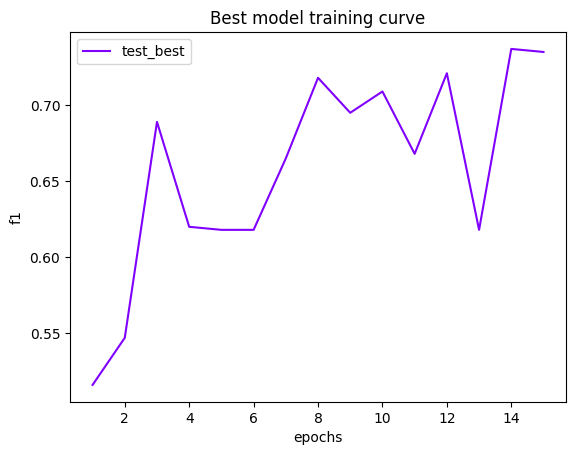

In [ ]:
project.plot_episodes(
    ["my_first_episode"],
    metrics=["f1"], # F1 score
    title="Best model training curve"
)

We can also check out more metrics now. See `project.help("metrics")` to see other options.

In [ ]:
project.evaluate(
    ["my_first_episode"],
    parameters_update={
        "general": {"metric_functions": ["segmental_f1", "mAP", "f1"]},
        "metrics": {
            "f1": {"average": "none"}
        }
    }
)

EVALUATION test_best
episode test_best
Number of samples:
    validation:
      {-100: 161290, 0: 707, 2: 42341, 3: 27320, 1: 7446}
    training:
      {-100: 649094, 2: 163336, 0: 2374, 3: 92604, 1: 26480}
    test:
      {1: 0, 2: 0, 3: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    0.768, 0.069, 0.011, 0.02
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


  0%|          | 0/8 [00:00<?, ?it/s]/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

100%|██████████| 8/8 [00:16<00:00,  2.08s/it]




AGGREGATED:
f1_0 0.652, f1_1 0.562, f1_2 0.935, f1_3 0.792, mAP 0.160, segmental_f1 0.195
Inference time: 0:00:16




{'segmental_f1': 0.19543121755123138,
 'mAP': 0.16007250271489554,
 'f1_0': 0.652375340461731,
 'f1_1': 0.5615978240966797,
 'f1_2': 0.9347875714302063,
 'f1_3': 0.7916250228881836}

## Using trained models

When you find that you are happy with the results, you can use the model to generate predictions for new data. 

Predictions here are probabilities of each behavior being seen in each frame while suggestions are suggested intervals generated from those probabilities.

Let's generate a prediction with one of our models and look at one of the resulting files. Note that you can use multiple models and average over their predictions.

In [ ]:
project.run_prediction(
    "my_first_prediction",
    episode_names=["my_first_episode"],
    force=True
)

PREDICTION test_best_prediction
episode test_best
Computing input features...


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 27.94it/s]


Filtering 4.34% of samples
Number of samples:
    validation:
      {1: 0, 2: 0, 3: 0, 0: 0}
    training:
      {-100: 810384, 2: 205677, 0: 3081, 3: 119924, 1: 33926}
    test:
      {1: 0, 2: 0, 3: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    0.744, 0.068, 0.011, 0.019
Behavior indices:
    0: other
    1: Grooming
    2: Supported
    3: Unsupported


  0%|          | 0/36 [00:00<?, ?it/s]/home/liza/DLC2Action_minimal/dlc2action/model/c2f_tcn.py:93: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

100%|██████████| 36/36 [01:08<00:00,  1.89s/it]


In [ ]:
import pickle
import os


# picking a random file from the prediction folder
prediction_folder = project.prediction_path("my_first_prediction")
prediction_file = os.listdir(prediction_folder)[0]
prediction_file = os.path.join(prediction_folder, prediction_file)

with open(prediction_file, "rb") as f: # open the file
    prediction = pickle.load(f)

for key, value in prediction.items(): # explore the contents
    if key not in ["max_frames", "min_frames", "video_tag", "behaviors"]:
        print(f'{key}: {value.shape}')
    
behaviors_order = project.get_behavior_dictionary("my_first_episode")

start = 50
end = 70
action = "Unsupported"

index = [k for k,v in behaviors_order.items() if v == action][0]
print(f'The mean probability of {action} between frames {start} and {end} is {prediction["ind0"][index, start: end].mean()}')

ind0: torch.Size([4, 15227])
The mean probability of Unsupported between frames 50 and 70 is 2.8996411856496707e-05


We will now remove unnecessary data to clean the memory.

In [11]:
project.remove_saved_features()
project.remove_extra_checkpoints()

Removing datasets...


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]
